In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.integrate import odeint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
csvs = [el for el in sorted(os.listdir('../data/csv_data/'), reverse=True) if 'csv' in el]

In [5]:
data = pd.DataFrame(columns = ['CCAA', 'fecha', 'casos', 'IA', 'UCI', 'muertes'])
for csv in csvs:
    data_int = pd.read_csv('../data/csv_data/{}'.format(csv),engine='python')
    data = data.append(data_int, ignore_index=True).reset_index(drop=True)

Corregir error primera muerte C. Valenciana

In [6]:
data.loc[data.loc[data.CCAA == '1'].index -1, 'muertes'] = 1
data = data.drop(data.loc[data.CCAA == '1'].index).reset_index(drop=True)

Único nombre para Castilla y La Mancha

In [7]:
data.loc[data.CCAA == 'Castilla-LaMancha', 'CCAA'] = 'CastillaLaMancha'

Damos formato a las columnas

In [8]:
data['fecha'] = pd.to_datetime(data['fecha'],format='%d.%m.%Y')
data['casos'] = pd.to_numeric(data.casos)
data['UCI'] = pd.to_numeric(data.UCI)
data['muertes'] = pd.to_numeric(data.muertes)

In [9]:
data = data.sort_values(by=['CCAA','fecha']).reset_index(drop = True)

## Casos en fin de semana

In [10]:
def date_lag(vect):
    days = np.array([el.day for el in vect])
    dif = days[1:] - days[:-1]
    return np.where(dif>1)[0]

In [11]:
def get_splits(df,ind):    
    return df.loc[:ind],df.loc[ind+1:]

In [12]:
def get_new_lines(df, ind):
    lines = pd.DataFrame({'CCAA': df.loc[ind-1:ind,'CCAA'].values,
                          'fecha': [df.loc[ind,'fecha']  + pd.DateOffset(1), df.loc[ind,'fecha']  + pd.DateOffset(2)],
                          'casos' : [np.nan, np.nan], 'IA' : [np.nan, np.nan], 
                          'UCI' : [np.nan, np.nan], 'muertes' : [np.nan, np.nan]})
    return lines

In [13]:
def get_line_eq(points):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords, rcond=-1)[0]
    return m, c

In [14]:
def fill_gaps(df, var, ind, rnd):
    point0 = (df.loc[ind,'fecha'].day,df.loc[ind,var])
    point1 = (df.loc[ind+3,'fecha'].day,df.loc[ind+3,var])
    m, c = get_line_eq([point0,point1])
    val0 = np.round(m*df.loc[ind+1,'fecha'].day+c,rnd)
    val1 = np.round(m*df.loc[ind+2,'fecha'].day+c,rnd)
    return val0, val1

In [15]:
def CCAA_correction(df):
    df = df.reset_index(drop=True)
    ind = date_lag(df['fecha'])
    while len(ind)>0:
        split1, split2 = get_splits(df, ind[0])
        lines = get_new_lines(df, ind[0])
        df = pd.concat([split1, lines, split2]).reset_index(drop=True)
        variables = list(df.columns)
        c = variables.index('fecha')+1
        rounds = [0,2,0,0]
        for var, r in zip(variables[c:],rounds):
            df.loc[ind[0]+1, var], df.loc[ind[0]+2, var] = fill_gaps(df, var, ind[0], r)
        ind = date_lag(df['fecha'])
    return df

In [16]:
_data_ = pd.DataFrame(columns = ['CCAA', 'fecha', 'casos', 'IA', 'UCI', 'muertes'])
for CCAA in data.CCAA.unique():
    data_int = CCAA_correction(data[data.CCAA == CCAA])
    _data_ = _data_.append(data_int, ignore_index=True).reset_index(drop=True)

In [17]:
del data
data = _data_.copy()
del _data_

In [23]:
data.to_csv('../data/csv_data/data/dataCOVID19_es.csv',index=False)

# Nuevos casos / CCAA

In [24]:
data['nuevos_casos'] = np.nan
for CCAA in data.CCAA.unique():
    casos_hoy  = data.loc[data.CCAA == CCAA,'casos'].values[1:]
    casos_ayer = data.loc[data.CCAA == CCAA,'casos'].values[:-1]
    data.loc[data.CCAA == CCAA,'nuevos_casos'] = [np.nan]+list(casos_hoy-casos_ayer)

In [25]:
#data['FC'] = np.nan
#for CCAA in data.CCAA.unique():
#    casos_hoy  = data.loc[data.CCAA == CCAA,'nuevos_casos'].values[2:]
#    casos_ayer = data.loc[data.CCAA == CCAA,'nuevos_casos'].values[1:-1]
#    data.loc[data.CCAA == CCAA,'FC'] = [np.nan,np.nan]+list(casos_hoy/casos_ayer)

# Gráficos

## Casos / CCAA

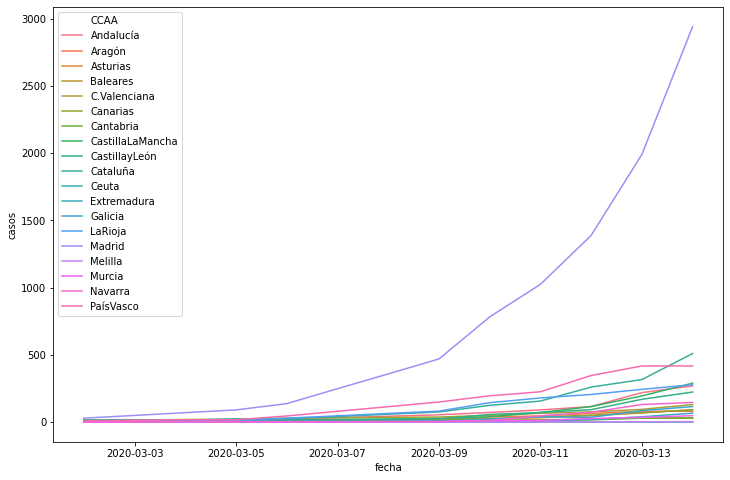

In [27]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="casos", hue='CCAA', data=data);

# Nuevos casos / CCAA

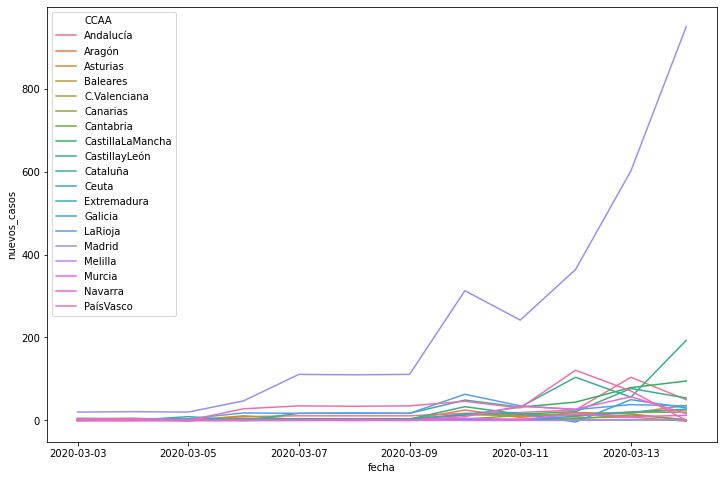

In [28]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="nuevos_casos", hue='CCAA', data=data);

## Incidencia acumulada / CCAA

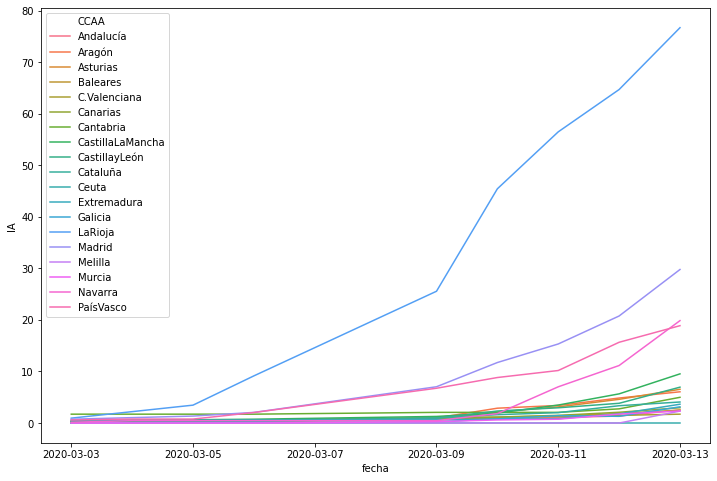

In [29]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="IA", hue='CCAA', data=data);

## UCI / CCAA

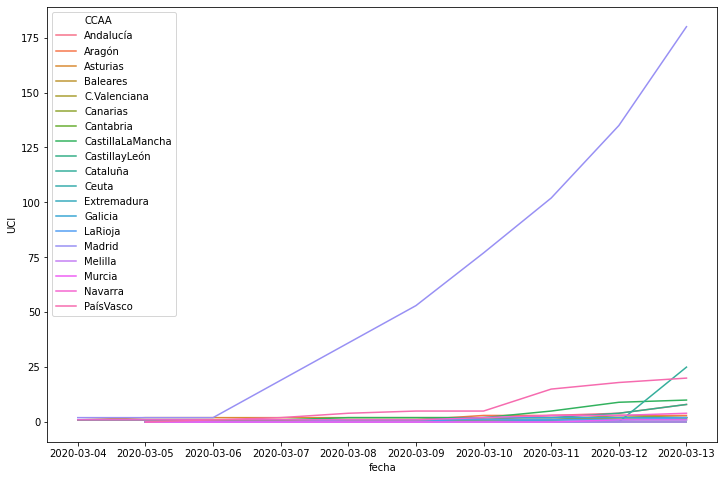

In [30]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="UCI", hue='CCAA', data=data);

## Muertes / CCAA

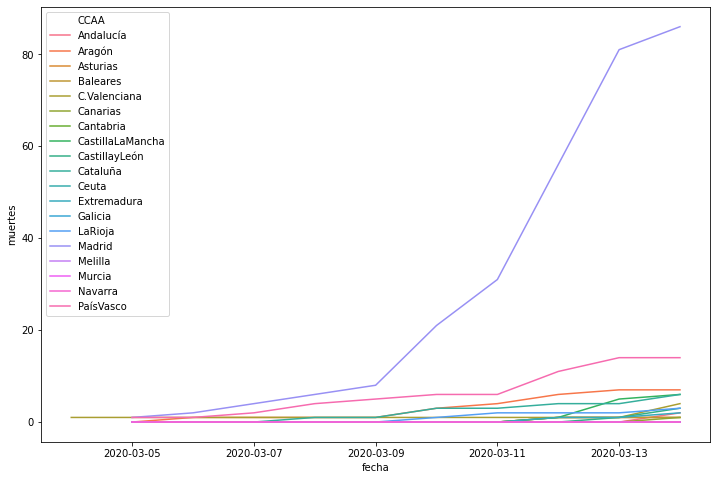

In [31]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="muertes", hue='CCAA', data=data);